# Does it work?

## Looking at game ratings and net rating

First, let's examine the relationship between player impact and team net rating.

In [1]:
import os
from pathlib import Path
import tempfile

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from nbaspa.data.endpoints.parameters import ParameterValues, SEASONS
from nbaspa.data.factory import NBADataFactory
from nbaspa.model.pipeline import gen_predict_pipeline, run_pipeline

In [2]:
calls = []
for season in SEASONS:
    for team in ParameterValues().TeamID:
        if team == 0:
            continue
        calls.append(("TeamLineups", {"TeamID": team, "Season": season, "output_dir": os.path.join(os.environ["DATA_DIR"], season)}))

In [3]:
loader = NBADataFactory(calls=calls)
_ = loader.load()

|████████████████████████████████████████| 480/480 [100%] in 3.7s (128.98/s)
[2021-10-16 19:23:13+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'Predict survival probability'
[2021-10-16 19:23:13+0000] INFO - prefect.TaskRunner | Task 'model': Starting task run...
[2021-10-16 19:23:13+0000] INFO - prefect.TaskRunner | Task 'model': Finished task run for task with final state: 'Success'
[2021-10-16 19:23:13+0000] INFO - prefect.TaskRunner | Task 'data_dir': Starting task run...
[2021-10-16 19:23:13+0000] INFO - prefect.TaskRunner | Task 'data_dir': Finished task run for task with final state: 'Success'
[2021-10-16 19:23:13+0000] INFO - prefect.TaskRunner | Task 'Season': Starting task run...
[2021-10-16 19:23:13+0000] INFO - prefect.TaskRunner | Task 'Season': Finished task run for task with final state: 'Success'
[2021-10-16 19:23:13+0000] INFO - prefect.TaskRunner | Task 'Load model': Starting task run...
[2021-10-16 19:23:13+0000] INFO - prefect.Load model | Reading model 

In [4]:
overall = loader.get_data("Overall")
avg_rating = np.average(overall["E_NET_RATING"].values)

In [5]:
ratings = pd.concat(
    (
        pd.read_csv(fpath, sep="|", index_col=0, dtype={"GAME_ID": str})
        for fpath in Path(os.environ["DATA_DIR"]).glob("*/game-impact/data_*.csv")
    ),
    ignore_index=True
)

In [6]:
ratings.loc[
    ratings["GAME_ID"].str[3:5].astype(int) + 1 >= 10, "SEASON"
] = (
    ratings["GAME_ID"].str[2]
    + "0"
    + ratings["GAME_ID"].str[3:5]
    + "-"
    + (ratings["GAME_ID"].str[3:5].astype(int) + 1).astype(str)
)
ratings.loc[
    ratings["GAME_ID"].str[3:5].astype(int) + 1 < 10, "SEASON"
] = (
    ratings["GAME_ID"].str[2]
    + "0"
    + ratings["GAME_ID"].str[3:5]
    + "-0"
    + (ratings["GAME_ID"].str[3:5].astype(int) + 1).astype(str)
)

In [7]:
agg = ratings.groupby(["PLAYER_ID", "TEAM_ID", "SEASON"])[["IMPACT", "IMPACT+"]].sum()
agg.reset_index(inplace=True)

In [8]:
bin_result, edges = pd.qcut(overall["E_NET_RATING"], q=5, retbins=True)
edges = np.round(edges, 1)
bin_result.cat.rename_categories([f"{edges[i-1]} to {edges[i]}" for i in range(1, len(edges))], inplace=True)

In [9]:
overall["RATING_BIN"] = bin_result
agg["RATING_BIN"] = pd.merge(agg, overall, left_on=("TEAM_ID", "SEASON"), right_on=("TEAM_ID", "GROUP_VALUE"), how="left")["RATING_BIN"]

- Player-level ratings across team bins overlap and have similar means. Variance on better teams is lower, with "good" teams having the highest ceiling.

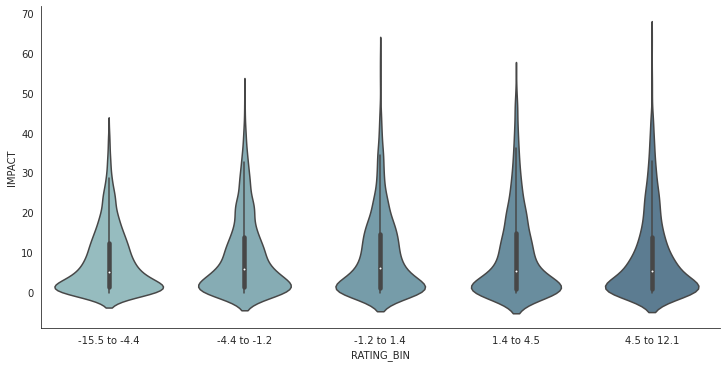

In [10]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    sns.catplot(
        x="RATING_BIN",
        y="IMPACT",
        data=agg,
        kind="violin",
        aspect=2,
        palette=sns.cubehelix_palette(10, rot=-.25, light=.7)
    )

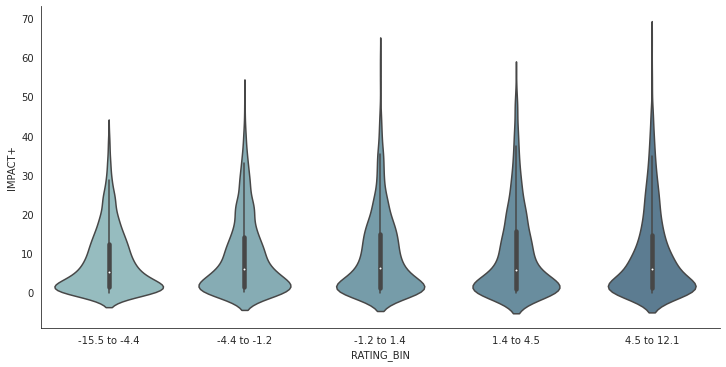

In [11]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    sns.catplot(
        x="RATING_BIN",
        y="IMPACT+",
        data=agg,
        kind="violin",
        aspect=2,
        palette=sns.cubehelix_palette(10, rot=-.25, light=.7)
    )

# TEAM-SEASON Aggregation

- Hypothesis: Mediocre teams will have high average impact ratings because they are in more close games

In [12]:
agg_team = ratings.groupby(["TEAM_ID", "SEASON"])[["IMPACT", "IMPACT+"]].sum()
agg_team.reset_index(inplace=True)
agg_team["RATING_BIN"] = pd.merge(agg_team, overall, left_on=("TEAM_ID", "SEASON"), right_on=("TEAM_ID", "GROUP_VALUE"), how="left")["RATING_BIN"]

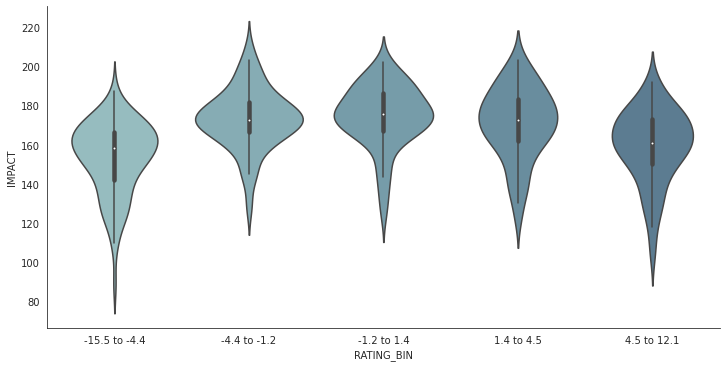

In [13]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    sns.catplot(
        x="RATING_BIN",
        y="IMPACT",
        data=agg_team,
        kind="violin",
        aspect=2,
        palette=sns.cubehelix_palette(10, rot=-.25, light=.7)
    )

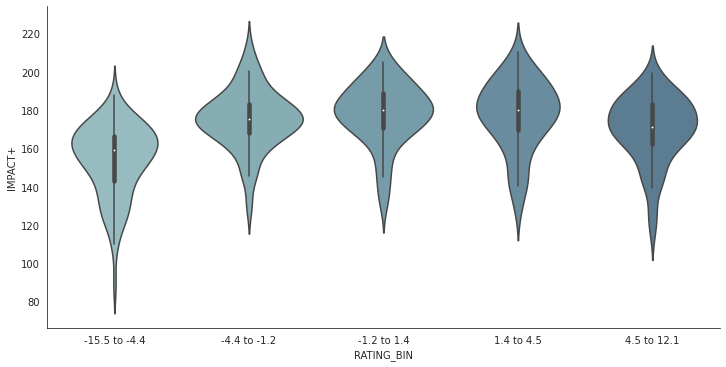

In [14]:
with sns.axes_style(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}):
    sns.catplot(
        x="RATING_BIN",
        y="IMPACT+",
        data=agg_team,
        kind="violin",
        aspect=2,
        palette=sns.cubehelix_palette(10, rot=-.25, light=.7)
    )

# Look at the swings in win probability by margin

- Hypothesis: the survival probability will be highly responsive to the margin of the game. This means that players that play more minutes in blowouts will be underestimated (both elite and awful teams).

In [15]:
with tempfile.TemporaryDirectory() as tmpdir:
    # Create a reference file
    np.random.seed(42)
    example = pd.DataFrame(
        {
            "GAME_ID": "00219DUMMY10",
            "HOME_W_PCT": 0.5,
            "VISITOR_W_PCT": 0.5,
            "LAST_GAME_WIN": 1,
            "HOME_GAMES_IN_LAST_3_DAYS": 0,
            "HOME_GAMES_IN_LAST_5_DAYS": 0,
            "HOME_GAMES_IN_LAST_7_DAYS": 0,
            "VISITOR_GAMES_IN_LAST_3_DAYS": 0,
            "VISITOR_GAMES_IN_LAST_5_DAYS": 0,
            "VISITOR_GAMES_IN_LAST_7_DAYS": 0,
            "HOME_NET_RATING": 0.0,
            "VISITOR_NET_RATING": 0.0,
            "TIME": np.concatenate(
                [np.zeros(1,), np.sort(np.random.randint(1, 2880, size=99))]
            ),
            "WIN": False,
            "NBA_WIN_PROB": np.round(np.random.uniform(0, 0.999, size=100), 3),
            "HOME_LINEUP_PLUS_MINUS": 0.0,
            "VISITOR_LINEUP_PLUS_MINUS": 0.0,
        }
    )
    steps = np.random.choice(
        [-2, -1, 0, 1, 2, 3], size=99, p=[0.1, 0.2, 0.5, 0.05, 0.1, 0.05]
    )
    example["SCOREMARGIN"] = np.concatenate([np.zeros(1,), steps]).cumsum(0)
    example.loc[99, "WIN"] = True
    # Create output directory
    output_dir = Path(tmpdir, "2019-20", "model-data")
    output_dir.mkdir(parents=True, exist_ok=True)
    # Write the existing data to the temporary data
    example.to_csv(output_dir / "data_00219DUMMY10.csv", sep="|")
    
    for i in range(1, 5):
        tmp_df = example.copy()
        tmp_df["GAME_ID"] = f"00219DUMMY1{i}"
        tmp_df["SCOREMARGIN"] += i * 5
        tmp_df.to_csv(output_dir / f"data_00219DUMMY1{i}.csv", sep="|")

    # Run the prediction pipeline
    flow = gen_predict_pipeline()
    run_pipeline(
        flow=flow,
        data_dir=tmpdir,
        output_dir=tmpdir,
        model=Path(os.environ["DATA_DIR"], "models", "2021-07-17", "lifelines", "model.pkl"),
        Season="2019-20"
    )

    # Load the output data back
    output = pd.concat(
        (
            pd.read_csv(fpath, sep="|", index_col=0, dtype={"GAME_ID": str})
            for fpath in Path(tmpdir, "2019-20", "survival-prediction").glob("data_*.csv")
        ),
        ignore_index=True
    )


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
example

,GAME_ID,HOME_W_PCT,VISITOR_W_PCT,LAST_GAME_WIN,HOME_GAMES_IN_LAST_3_DAYS,HOME_GAMES_IN_LAST_5_DAYS,HOME_GAMES_IN_LAST_7_DAYS,VISITOR_GAMES_IN_LAST_3_DAYS,VISITOR_GAMES_IN_LAST_5_DAYS,VISITOR_GAMES_IN_LAST_7_DAYS,HOME_NET_RATING,VISITOR_NET_RATING,TIME,WIN,NBA_WIN_PROB,HOME_LINEUP_PLUS_MINUS,VISITOR_LINEUP_PLUS_MINUS,SCOREMARGIN
0,00219DUMMY10,0.5,0.5,1,0,0,0,0,0,0,0.0,0.0,0.0,False,0.199,0.0,0.0,0.0
1,00219DUMMY10,0.5,0.5,1,0,0,0,0,0,0,0.0,0.0,22.0,False,0.711,0.0,0.0,0.0
2,00219DUMMY10,0.5,0.5,1,0,0,0,0,0,0,0.0,0.0,35.0,False,0.789,0.0,0.0,-2.0
3,00219DUMMY10,0.5,0.5,1,0,0,0,0,0,0,0.0,0.0,65.0,False,0.605,0.0,0.0,0.0
4,00219DUMMY10,0.5,0.5,1,0,0,0,0,0,0,0.0,0.0,131.0,False,0.925,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,00219DUMMY10,0.5,0.5,1,0,0,0,0,0,0,0.0,0.0,2748.0,False,0.858,0.0,0.0,25.0
96,00219DUMMY10,0.5,0.5,1,0,0,0,0,0,0,0.0,0.0,2768.0,False,0.326,0.0,0.0,25.0
97,00219DUMMY10,0.5,0.5,1,0,0,0,0,0,0,0.0,0.0,2778.0,False,0.220,0.0,0.0,24.0
98,00219DUMMY10,0.5,0.5,1,0,0,0,0,0,0,0.0,0.0,2825.0,False,0.710,0.0,0.0,24.0


In [17]:
df_list = []
for name, group in output.groupby("GAME_ID"):
    newid = int(name[-1])
    if newid == 0:
        group["Margin"] = "Reference"
    else:
        group["Margin"] = f"+{newid * 5}"
    group["EVENT_IMPACT"] = group["WIN_PROB"].diff().bfill()
    df_list.append(group)

columns = ["Margin", "SCOREMARGIN", "TIME", "WIN_PROB", "EVENT_IMPACT"]

graphing = pd.concat(df_list, ignore_index=True)

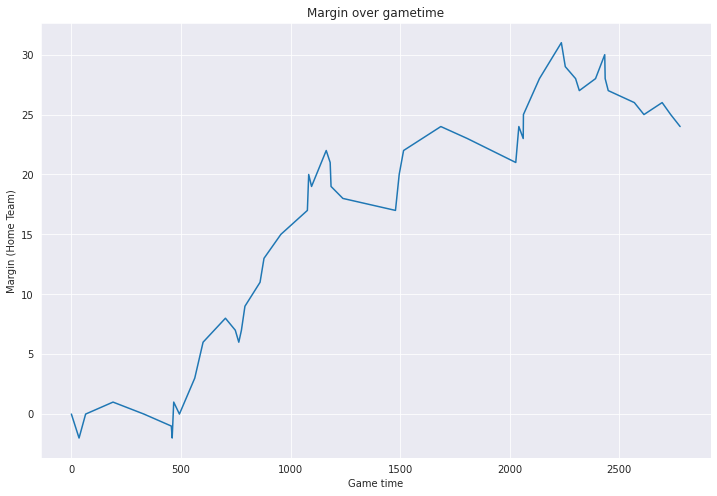

In [18]:
with sns.axes_style(style="darkgrid"):
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.lineplot(
        x="TIME",
        y="SCOREMARGIN",
        data=df_list[0],
        ax=ax
    ).set(
        title="Margin over gametime",
        xlabel="Game time",
        ylabel="Margin (Home Team)"
    )

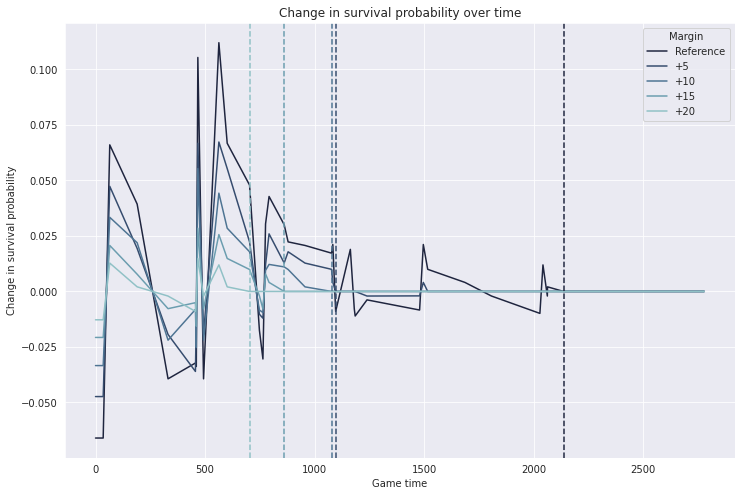

In [19]:
with sns.axes_style(style="darkgrid"):
    fig, ax = plt.subplots(figsize=(12, 8))
    palette = sns.cubehelix_palette(5, rot=-0.25, light=0.7, reverse=True)
    sns.lineplot(
        x="TIME",
        y="EVENT_IMPACT",
        hue="Margin",
        data=graphing,
        palette=palette,
        ax=ax
    ).set(
        title="Change in survival probability over time",
        xlabel="Game time",
        ylabel="Change in survival probability"
    )
    # Add vertical lines for the first zero-impact events
    for idx, df in enumerate(df_list):
        zero = df[df["EVENT_IMPACT"] == 0.0]
        if zero.empty:
            continue
        first_ = zero["TIME"].idxmin()
        plt.axvline(graphing.loc[first_, "TIME"], linestyle="--", color=palette[idx])